# Importing packages

In [45]:
import fedjax
import jax
import jax.numpy as jnp
import PLM_computation
import FedMix_computation
from grid_search import FedMixGrid, grid_search
from EMNIST_custom import emnist_load_gd_data
import itertools

In [71]:
from matplotlib import pyplot as plt

In [80]:
import pickle

# Model setup

In [2]:
model = fedjax.models.emnist.create_conv_model(only_digits=False)

In [3]:
def loss(params, batch, rng):
    # `rng` used with `apply_for_train` to apply dropout during training.
    preds = model.apply_for_train(params, batch, rng)
    # Per example loss of shape [batch_size].
    example_loss = model.train_loss(batch, preds)
    return jnp.mean(example_loss)

In [4]:
def loss_for_eval(params, batch):
    preds = model.apply_for_eval(params, batch)
    example_loss = model.train_loss(batch, preds)
    return jnp.mean(example_loss)

In [5]:
grad_fn = jax.jit(jax.grad(loss))

In [6]:
grad_fn_eval = jax.jit(jax.grad(loss_for_eval))

# Grid search setup

## Constants

In [8]:
CACHE_DIR = '../data/'
NUM_CLIENTS_GRID_SEARCH = 200
TRAIN_VALIDATION_SPLIT = 0.8
NUM_CLIENTS_PER_PLM_ROUND = 5
NUM_CLIENTS_PER_FEDMIX_ROUND = 10
FEDMIX_ALGORITHM = 'adam'
FEDMIX_NUM_ROUNDS = 500
PLM_NUM_EPOCHS = 100

## Datasets and parameters

In [9]:
train_fd, validation_fd = emnist_load_gd_data(
    train_val_split=TRAIN_VALIDATION_SPLIT,
    only_digits=False,
    cache_dir=CACHE_DIR
)

Reusing cached file '../data/federated_emnist_train.sqlite'


In [10]:
client_ids = set([cid for cid in itertools.islice(
    train_fd.client_ids(), NUM_CLIENTS_GRID_SEARCH)])

In [11]:
train_fd = fedjax.SubsetFederatedData(train_fd, client_ids)
validation_fd = fedjax.SubsetFederatedData(validation_fd, client_ids)

In [14]:
plm_init_params = model.init(jax.random.PRNGKey(0))

In [15]:
plm_comp_params = PLM_computation.PLMComputationProcessParams(
    plm_init_params, NUM_CLIENTS_PER_PLM_ROUND)

In [16]:
fedmix_init_params = model.init(jax.random.PRNGKey(20))

In [17]:
fedmix_comp_params = FedMix_computation.FedMixComputationParams(
    FEDMIX_ALGORITHM, fedmix_init_params, FEDMIX_NUM_ROUNDS)

In [18]:
alpha = 0.7

## Grid

In [22]:
fedmix_lrs = 10**jnp.arange(-5., 0.5, 1)
fedmix_batch_sizes = [20, 50, 100, 200]
plm_lrs = 10**jnp.arange(-5., 0.5, 1)
plm_batch_sizes = [10, 20, 50, 100]

In [23]:
grid = FedMixGrid(fedmix_lrs, plm_lrs, fedmix_batch_sizes, plm_batch_sizes)

# Grid search

In [28]:
SAVE_FILE = '../results/EMNIST_{}_gd.npy'.format(int(10 * alpha))

In [30]:
SAVE_FILE

'../results/EMNIST_7_gd.npy'

In [ ]:
table = grid_search(
    train_fd, validation_fd, grad_fn, grad_fn_eval, model, alpha,
    plm_comp_params, fedmix_comp_params, grid, PLM_NUM_EPOCHS,
    NUM_CLIENTS_PER_FEDMIX_ROUND, SAVE_FILE
)

PLM computation: num_epochs = 100, lr = 9.999999747378752e-06, b_size = 10


In [34]:
best_ind = jnp.unravel_index(jnp.argmax(table), table.shape)

In [59]:
best_ind

(DeviceArray(2, dtype=int32),
 DeviceArray(2, dtype=int32),
 DeviceArray(2, dtype=int32),
 DeviceArray(3, dtype=int32))

In [35]:
plm_batch_size = plm_batch_sizes[best_ind[0]]
plm_lr = plm_lrs[best_ind[1]]
fedmix_batch_size = fedmix_batch_sizes[best_ind[2]]
fedmix_lr = fedmix_lrs[best_ind[3]]

# FedMix

In [64]:
num_rounds = 3000

Now we download full train and test datasets.

In [42]:
train_fd, test_fd = fedjax.datasets.emnist.load_data(only_digits=False,
                                                     cache_dir='../data/')

Reusing cached file '../data/federated_emnist_train.sqlite'
Reusing cached file '../data/federated_emnist_test.sqlite'


In [51]:
plm_comp_hparams = PLM_computation.PLMComputationHParams(PLM_NUM_EPOCHS,
                                                         plm_lr,
                                                         plm_batch_size)

In [ ]:
PLM_dict = PLM_computation.plm_computation(train_fd,
                                           grad_fn,
                                           plm_comp_hparams,
                                           plm_comp_params)

PLM computation: num_epochs = 100, lr = 0.0010000000474974513, b_size = 50


In [56]:
alpha

0.7

In [57]:
alpha_dict = {}
for cid in train_fd.client_ids():
    alpha_dict[cid] = alpha

In [58]:
len(alpha_dict)

3400

In [60]:
fedmix_hparams = FedMix_computation.FedMixHParams(
    fedmix_lr, NUM_CLIENTS_PER_FEDMIX_ROUND, fedmix_batch_size)

In [62]:
fedmix_batch_size

100

In [65]:
fedmix_comp_params = FedMix_computation.FedMixComputationParams(
    FEDMIX_ALGORITHM, fedmix_init_params, num_rounds)

In [66]:
_, stats = FedMix_computation.fedmix_computation_with_statistics(
    train_fd, test_fd, grad_fn, grad_fn_eval, model, PLM_dict, alpha_dict,
    fedmix_hparams, fedmix_comp_params, 100)

# FedAvg

In [ ]:
client_optimizer = fedjax.optimizers.sgd(learning_rate=10**(-1.5))
server_optimizer = fedjax.optimizers.adam(
learning_rate=10**(-2.5), b1=0.9, b2=0.999, eps=10**(-4))
# Hyperparameters for client local traing dataset preparation.
client_batch_hparams = fedjax.ShuffleRepeatBatchHParams(batch_size=20)
algorithm = fedjax.algorithms.fed_avg.federated_averaging(grad_fn, client_optimizer,
                                          server_optimizer,
                                          client_batch_hparams)
# Initialize model parameters and algorithm server state.
init_params = model.init(jax.random.PRNGKey(17))
server_state = algorithm.init(init_params)

In [ ]:
train_client_sampler = fedjax.client_samplers.UniformGetClientSampler(fd=train_fd, num_clients=10, seed=0)

In [ ]:
fedavg_test_acc_progress = []

In [ ]:
for round_num in range(1, max_rounds + 1):
    # Sample 10 clients per round without replacement for training.
    clients = train_client_sampler.sample()
    # Run one round of training on sampled clients.
    server_state, client_diagnostics = algorithm.apply(server_state, clients)
    print(f'[round {round_num}]', end='\r')
    # Optionally print client diagnostics if curious about each client's model
    # update's l2 norm.
    # print(f'[round {round_num}] client_diagnostics={client_diagnostics}')

    if round_num % 100 == 0:
        test_eval_datasets = [cds for _, cds in test_fd.clients()]
        test_eval_batches = fedjax.padded_batch_client_datasets(test_eval_datasets, batch_size=256)
        test_metrics = fedjax.evaluate_model(model, server_state.params, test_eval_batches)
        fedavg_test_acc_progress.append(test_metrics['accuracy'])
        print('Test accuracy = {}'.format(test_metrics['accuracy']))

In [81]:
save_file = '../results/test_acc_fedavg.pickle'

In [ ]:
with open(save_file, 'wb') as handle:
    pickle.dump(fedavg_test_acc_progress, handle)

In [82]:
with open(save_file, 'rb') as handle:
    fedavg_test_acc_progress = pickle.load(handle)

In [84]:
fedavg_test_acc_progress = fedavg_test_acc_progress[:30]

# Plots

In [69]:
accs = [stat['accuracy'] for stat in stats]

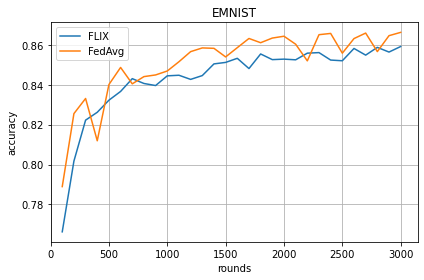

In [89]:
round_nums = jnp.linspace(100, 3000, num=30, endpoint=True)
plt.plot(round_nums, accs, label='FLIX')
plt.plot(round_nums, fedavg_test_acc_progress, label='FedAvg')
plt.xlim(left=0)
plt.ylabel('accuracy')
plt.xlabel('rounds')
plt.grid()
plt.title('EMNIST')
plt.legend()
plt.tight_layout()
plt.savefig('../results/plots/EMNIST_preliminary_7.pdf')